In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [5]:
df = pd.read_csv('data/p1_train.csv')
X, Y = df.drop(['class'], axis=1), df['class']

In [6]:
Y[Y == 'MmMmM'].shape

(544,)

In [7]:
Y[Y == 'QqQqQ'].shape

(987,)

In [8]:
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)

In [9]:
from keras import Sequential
from keras.api.layers import Input, Dense
from keras.api.optimizers import SGD
from keras.api.callbacks import EarlyStopping
from keras.api.optimizers.schedules import ExponentialDecay
from keras.api.initializers import Zeros, RandomNormal
from keras.api.regularizers import l1, l2

In [10]:
model = Sequential()
model.add(Input(shape=(X.shape[-1],)))
model.add(Dense(units=32, activation='relu', kernel_initializer=RandomNormal(0, 1), kernel_regularizer=l1(0.01)))
model.add(Dense(units=1, activation='sigmoid', kernel_initializer=Zeros(), kernel_regularizer=l2(0.001)))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,057 (4.13 KB)

 Trainable params: 1,057 (4.13 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=1600,
    decay_rate=0.95,
    staircase=False
)
sgd_optimizer = SGD(learning_rate=lr_schedule)
model.compile(optimizer=sgd_optimizer, loss='binary_crossentropy', metrics=['accuracy', 'precision', 'recall'])
early_stop = EarlyStopping(monitor='loss', mode='min', min_delta=0.0001, patience=10, restore_best_weights=True)

In [12]:
history = model.fit(X, Y, epochs=300, batch_size=16, shuffle=True, class_weight={0:1.5, 1:1}, callbacks=[early_stop])

Epoch 1/300
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 815us/step - accuracy: 0.6279 - loss: 9.2009 - precision: 0.7485 - recall: 0.6309
Epoch 2/300
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - accuracy: 0.6817 - loss: 8.0465 - precision: 0.7820 - recall: 0.6992
Epoch 3/300
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - accuracy: 0.7257 - loss: 6.8991 - precision: 0.8207 - recall: 0.7516
Epoch 4/300
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - accuracy: 0.7366 - loss: 6.0049 - precision: 0.8095 - recall: 0.7640
Epoch 5/300
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - accuracy: 0.7745 - loss: 5.1420 - precision: 0.8521 - recall: 0.7847
Epoch 6/300
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - accuracy: 0.7571 - loss: 4.5233 - precision: 0.8320 - recall: 0.7788
Epoch 7/300
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - accuracy: 0.7976 - loss: 3.8844 - precision: 0.8592 - recall: 0.8266
Epoch 8/300
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - accuracy: 0.8153 - loss: 3.3182 - precision: 0.8667 - recall: 0.8413
Epoch 9/

In [13]:
df_test = pd.read_csv('data/p1_test_student.csv')
X_test, Y_test = df_test.drop(['class'], axis=1), df_test['class']
X_test = scaler.transform(X_test)
Y_predict = model.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [14]:
Y_test = encoder.transform(Y_test).reshape(-1, 1)
Y_test.shape

(305, 1)

In [15]:
Y_predict_labels = (Y_predict > 0.5).astype(int)

In [16]:
(Y_predict_labels == 1).sum(), (Y_predict_labels == 0).sum()

(np.int64(186), np.int64(119))

In [17]:
(Y_test == 1).sum(), (Y_test == 0).sum()

(np.int64(196), np.int64(109))

In [18]:
TP = ((Y_predict_labels == 1) & (Y_test == 1)).sum()
TF = ((Y_predict_labels == 0) & (Y_test == 0)).sum()
FP = ((Y_predict_labels == 1) & (Y_test != 1)).sum()
FN = ((Y_predict_labels == 0) & (Y_test == 1)).sum()
accuracy = (Y_predict_labels == Y_test).sum() / Y_test.shape[0]
precision = TP / (TP + FP)
recall =  TP / (TP + FN)
f1_score = 2 * precision * recall / (precision + recall)
print(f"accuracy: {accuracy}, precision: {precision}, recall: {recall}, f1_score: {f1_score}")

accuracy: 0.8557377049180328, precision: 0.9086021505376344, recall: 0.8622448979591837, f1_score: 0.8848167539267016


accuracy: 0.8721311475409836,
precision: 0.8905472636815921,
recall: 0.9132653061224489,
f1_score: 0.9017632241813602

In [19]:
FP, FN

(np.int64(17), np.int64(27))

In [20]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'precision', 'recall'])

In [21]:
from matplotlib import pyplot as plt

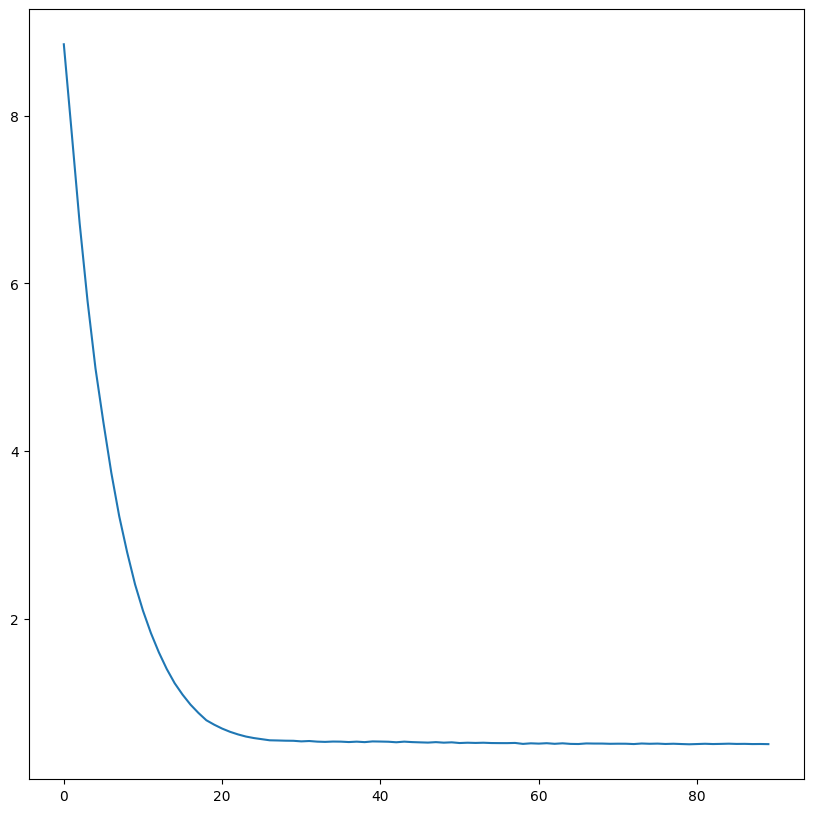

In [22]:
fig = plt.figure(figsize=(10, 10))
plt.plot([x for x in range(len(history.history['loss']))], history.history['loss'])

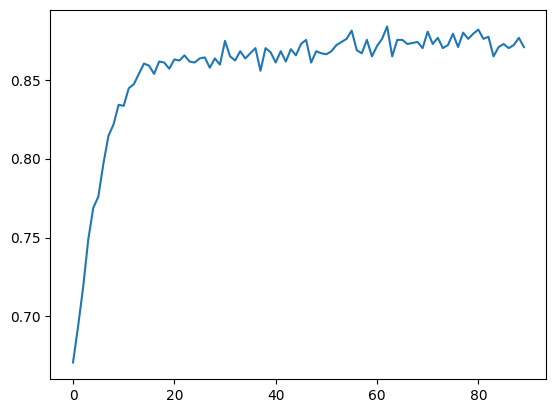

In [23]:
plt.plot([x for x in range(len(history.history['accuracy']))], history.history['accuracy'])

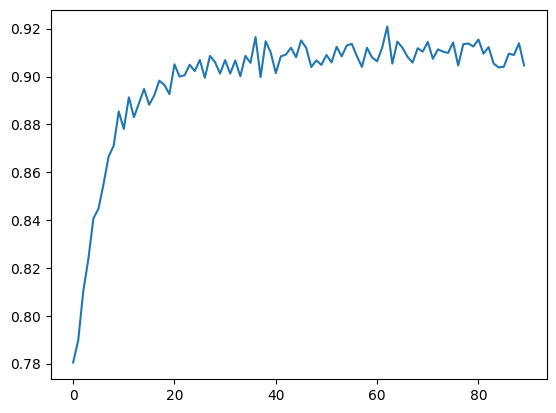

In [24]:
plt.plot([x for x in range(len(history.history['precision']))], history.history['precision'])

In [25]:
import numpy as np

In [26]:
probs = np.arange(0, 1, 0.1)
counts_positive = np.zeros(probs.size)
counts_negative = np.zeros(probs.size)
ind = 0
for prob in probs:
    counts_positive[ind] = Y_predict[(Y_predict > prob) & (Y_predict < prob + 0.1) & (Y_test == 1)].size
    counts_negative[ind] = Y_predict[(Y_predict > prob) & (Y_predict < prob + 0.1) & (Y_test == 0)].size
    ind += 1

<BarContainer object of 10 artists>

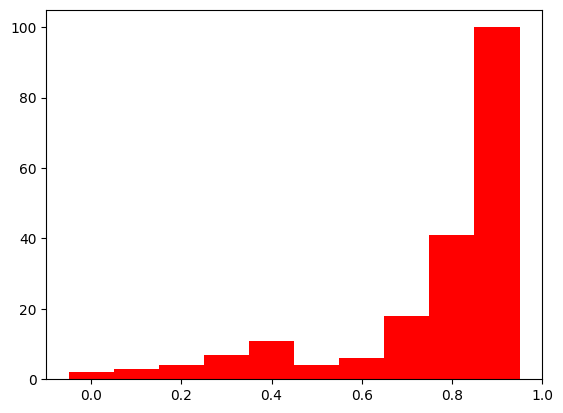

In [27]:
plt.bar(x=probs, height=counts_positive, width=0.1, color='r')

<BarContainer object of 10 artists>

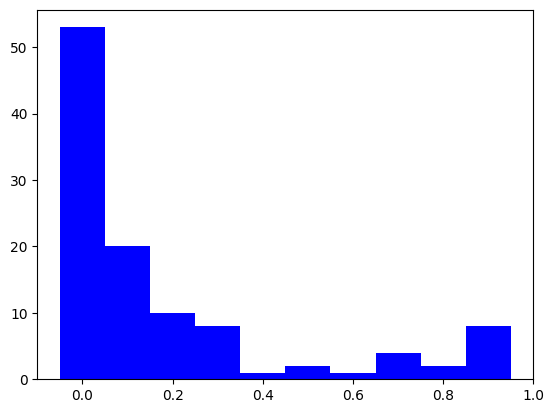

In [28]:
plt.bar(x=probs, height=counts_negative, width=0.1, color='b')

In [29]:
threshold_start = 0
threshold_stop = 1
precisions = list()
recalls = list()
for step in range(threshold_start, threshold_stop * 10, 1):
  threshold = step / 10
  Y_predict_labels = (Y_predict > threshold).astype(int)
  TP = ((Y_predict_labels == 1) & (Y_test == 1)).sum()
  TF = ((Y_predict_labels == 0) & (Y_test == 0)).sum()
  FP = ((Y_predict_labels == 1) & (Y_test != 1)).sum()
  FN = ((Y_predict_labels == 0) & (Y_test == 1)).sum()
  accuracy = (Y_predict_labels == Y_test).sum() / Y_test.shape[0]
  precision = TP / (TP + FP) if TP != 0 else 0
  recall =  TP / (TP + FN) if TP != 0 else 0
  precisions.append(precision)
  recalls.append(recall)

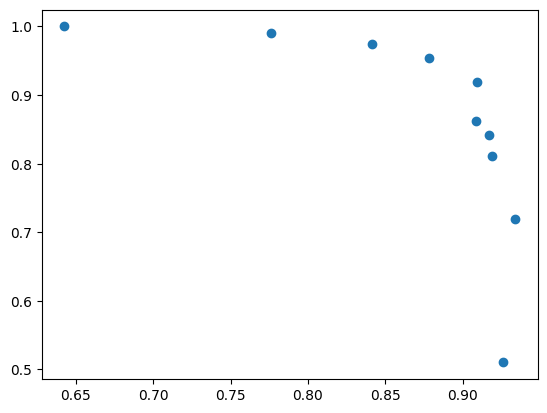

In [30]:
plt.scatter(precisions, recalls)